In [1]:
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout,Conv2D,BatchNormalization,Flatten,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import Counter
from tensorflow.keras.models import load_model
from glob import glob
import random
from tensorflow.keras.utils import Sequence
from random import randrange
import json
from scipy.ndimage import zoom
import matplotlib.pyplot as plt


# Get list of train and validation data

In [2]:
oModelPath = "D:\\ISS_project\\Model\\"
#input path for full image
oTrainFullImgPath = "D:\\ISS_project\\dataset\\prepared_data\\train"
oValFullImgPath = "D:\\ISS_project\\dataset\\prepared_data\\val"

def list_image_files(oInputPath):
    oImageFileNames = glob(oInputPath + "\\*.png")
    return oImageFileNames

oListTrainImgFiles =  list_image_files(oTrainFullImgPath)
oListValImgFiles = list_image_files(oValFullImgPath)

print("No: Training data :",len(oListTrainImgFiles))
print("No: Val data :",len(oListValImgFiles))

No: Training data : 101656
No: Val data : 30809


# Data Generator

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,image_path,Flag,
                 to_fit=True, batch_size=32, dim=(100,100),no_input = 5,
                 n_channels=3, n_classes=2, shuffle=True): 
        self.list_IDs = list_IDs
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.flag = Flag
        self.no_input = no_input
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X,y = self._generate_X(list_IDs_temp) 

        if self.to_fit:
            for k in range(0,X.shape[0]):
                if self.flag == 'train':
                    oAugIdx = randrange(4)
                    if oAugIdx == 1:
                        X[k,],y[k,] =self._horizontal_flip(X[k],y[k])
                    if oAugIdx == 2:
                        X[k,],y[k,]=self._random_zoom(X[k],y[k])
                    if oAugIdx == 3:
                        X[k,]=self._image_translation(X[k])
                    
            return X,y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size,3))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_image(ID)
            #getlabel file name
            oImageName = ID.split("\\")[-1]
            oImageName = oImageName.split(".png")[0]
            oLabelPath = os.path.join(self.image_path,oImageName+"_angles.txt")
            oLabel = []
            with open(oLabelPath, 'r') as f:
                oLabel = json.loads(f.read())
                #convert to radians
                oLabel[0] = oLabel[0] * np.pi/180
                oLabel[1] = oLabel[1] * np.pi/180
                oLabel[2] = oLabel[2] * np.pi/180
            Y[i,] = np.array(oLabel)
            #print("ID :",ID)
            #print("label : ",Y[i])
        return X,Y
    def _noisy(self,img, noise_type="gauss"):
        '''
        ### Adding Noise ###
        img: image
        cj_type: {gauss: gaussian, sp: salt & pepper}
        '''
        if noise_type == "gauss":
            image=img.copy() 
            mean=0
            st=0.7
            gauss = np.random.normal(mean,st,image.shape)
            gauss = gauss.astype('uint8')
            image = cv2.add(image,gauss)
            return image
    
        elif noise_type == "sp":
            image=img.copy() 
            prob = 0.05
            if len(image.shape) == 2:
                black = 0
                white = 255            
            else:
                colorspace = image.shape[2]
                if colorspace == 3:  # RGB
                    black = np.array([0, 0, 0], dtype='uint8')
                    white = np.array([255, 255, 255], dtype='uint8')
                else:  # RGBA
                    black = np.array([0, 0, 0, 255], dtype='uint8')
                    white = np.array([255, 255, 255, 255], dtype='uint8')
            probs = np.random.random(image.shape[:2])
            image[probs < (prob / 2)] = black
            image[probs > 1 - (prob / 2)] = white
            return image
    
    def _colorjitter(self,img, cj_type="b"):
        '''
        ### Different Color Jitter ###
        img: image
        cj_type: {b: brightness, s: saturation, c: constast}
        '''
        if cj_type == "b":
            #value = random.randint(-30, 30)
            value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if value >= 0:
                lim = 255 - value
                v[v > lim] = 255
                v[v <= lim] += value
            else:
                lim = np.absolute(value)
                v[v < lim] = 0
                v[v >= lim] -= np.absolute(value)

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
            return img
    
        elif cj_type == "s":
            # value = random.randint(-50, 50)
            value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if value >= 0:
                lim = 255 - value
                s[s > lim] = 255
                s[s <= lim] += value
            else:
                lim = np.absolute(value)
                s[s < lim] = 0
                s[s >= lim] -= np.absolute(value)

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
            return img
    
        elif cj_type == "c":
            brightness = 10
            contrast = random.randint(40, 100)
            dummy = np.int16(img)
            dummy = dummy * (contrast/127+1) - contrast + brightness
            dummy = np.clip(dummy, 0, 255)
            img = np.uint8(dummy)
            return img
    
    def _change_brightness(self,img, value):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.add(v,value)
        v[v > 255] = 255
        v[v < 0] = 0
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img

    def _horizontal_flip(self,x,y):
        x = cv2.flip(x, 1)
        y[1] = -1 * y[1]
        y[2] = -1 * y[2]
        #x = np.reshape(x,(x.shape[0],x.shape[1],1))
        return x,y
    def _image_translation(self,image):
        width = image.shape[1]
        height = image.shape[0]
        #tx = np.random.choice(np.array([-45, -40, -35,-30,-25,-20,45,40,35,30,25,20]))
        #ty = np.random.choice(np.array([-35,-30,-25,-20,45,40,35,30,25,20]))
        oRandIdx = randrange(3)
        if oRandIdx == 0:
            tx = np.random.choice(np.array([-45, -40, -35,-30,-25,-20,45,40,35,30,25,20]))
            ty = 0
        if oRandIdx == 1:
            ty = randrange(-35,35)
            tx = 0
        if oRandIdx == 2:   
            tx, ty = randrange(-45,45), randrange(-35,35)
        # create the translation matrix using tx and ty, it is a NumPy array
        translation_matrix = np.array([[1, 0, tx],[0, 1, ty]], dtype=np.float32)
        translated_image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height),borderMode = cv2.BORDER_REFLECT)
        return translated_image
    def _clipped_zoom(self,img, zoom_factor):

        h, w = img.shape[:2]

        # For multichannel images we don't want to apply the zoom factor to the RGB
        # dimension, so instead we create a tuple of zoom factors, one per array
        # dimension, with 1's for any trailing dimensions after the width and height.
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

        # Zooming out
        if zoom_factor < 1:

            # Bounding box of the zoomed-out image within the output array
            zh = int(np.round(h * zoom_factor))
            zw = int(np.round(w * zoom_factor))
            top = (h - zh) // 2
            left = (w - zw) // 2

            # Zero-padding
            out = np.zeros_like(img)
            out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple)

        # Zooming in
        elif zoom_factor > 1:

            # Bounding box of the zoomed-in region within the input array
            zh = int(np.round(h / zoom_factor))
            zw = int(np.round(w / zoom_factor))
            top = (h - zh) // 2
            left = (w - zw) // 2

            out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)

            # `out` might still be slightly larger than `img` due to rounding, so
            # trim off any extra pixels at the edges
            trim_top = ((out.shape[0] - h) // 2)
            trim_left = ((out.shape[1] - w) // 2)
            out = out[trim_top:trim_top+h, trim_left:trim_left+w]

        # If zoom_factor == 1, just return the input array
        else:
            out = img
        return out
    def _random_zoom(self,x,y):
        ranges =  randrange(10)
        while ranges == 4 or ranges == 6 or ranges == 0 or ranges == 9 or ranges == 8:
            ranges =  randrange(10)
        zoom_factor = 1 + ranges/10
        x = self._clipped_zoom(x, zoom_factor)
        return x,y
    
    def _load_image(self, image_path):
        #print("image_path :",image_path)
        img = cv2.imread(image_path)
        '''Change brightness'''
        if self.flag == 'train':
            oIdx = randrange(2)
            if oIdx == 1:
                oIdxType = randrange(3)
                cj_type = ["b","s","c"]
                #value = randrange(-30,30)
                img = self._colorjitter(img, cj_type=cj_type[oIdxType])
                
        '''Adding Noise'''
        if self.flag == 'train':
            oIdx = randrange(2)
            if oIdx == 1:
                oIdxType = randrange(2)
                noise_type = ["gauss","sp"]
                #value = randrange(-30,30)
                img = self._noisy(img, noise_type=noise_type[oIdxType])
                
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.equalizeHist(img)
        #mean = [0.485, 0.456, 0.406]
        #std = [0.229, 0.224, 0.225]
        img = img/255.0
        #img = (img - mean) / std
        #img = np.reshape(img,(img.shape[0],img.shape[1],1))
        #print("shape: ",img.shape)
        return img
    
flagTrain = 'train'    
oTrainGen = DataGenerator(oListTrainImgFiles,oTrainFullImgPath,flagTrain)
flagVal = 'val'
oValGen = DataGenerator(oListValImgFiles,oValFullImgPath,flagVal)

# Network Architecture

In [12]:
input_tensor = Input(shape=(100,100,3))
#x = tf.cast(input_tensor, tf.float32)
#x = tf.keras.applications.mobilenet.preprocess_input(x)    
#base_model = MobileNetV2(input_tensor=x,weights = 'imagenet',input_shape = (100,100,3), include_top=False)
#base_model.trainable = False    
# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#add a fully-connected layer and the output layer
#x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
#x = Dense(128, activation='tanh')(x)
#x = Dropout(0.5)(x)

'''custom architecture'''
#x = BatchNormalization()(input_tensor)
x = Conv2D(24, (5, 5), strides=(2,2), padding='valid', name='block1_conv1')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.2)(x)
#x = MaxPooling2D((2, 2), strides=None, name='block1_pool')(x)

x = Conv2D(48, (3,3), strides=(2,2),padding='valid', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.2)(x)
#x = MaxPooling2D((2, 2), strides=None, name='block2_pool')(x)

x = Conv2D(64, (3, 3),strides=(2,2), padding='valid', name='block3_conv3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3),strides=(1,1), padding='valid', name='block3.5_conv3.5')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.3)(x)

x = Conv2D(96, (3, 3),strides=(2,2), padding='valid', name='block4_conv4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.3)(x)
#x = GlobalAveragePooling2D()(x)
#x = MaxPooling2D((2, 2), strides=None, name='block3_pool')(x)
#x = Dropout(0.7, name='dropout_conv3')(x)
x = Conv2D(128, (3, 3),strides=(2,2), padding='valid', name='block5_conv5')(x)
#x = BatchNormalization()(x)
x = Activation('tanh')(x)

x = Dropout(0.3)(x)

x = Flatten(name='flatten1')(x)
#x = Dense(120, name='fc_1')(x)
#x = BatchNormalization()(x)
#x = Activation('tanh')(x)
x = Dropout(0.3, name='dropout_fc1')(x)
x = Dense(128, name='fc_2')(x)
#x = BatchNormalization()(x)
x = Activation('tanh')(x)

prediction = Dense(3, activation='linear')(x)

# create the model
model = Model(inputs=input_tensor, outputs=prediction)
model.summary()
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
model.compile(optimizer=adam, loss="mean_squared_error",metrics = ['mae'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 24)        1824      
_________________________________________________________________
batch_normalization_14 (Batc (None, 48, 48, 24)        96        
_________________________________________________________________
activation_20 (Activation)   (None, 48, 48, 24)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 48, 48, 24)        0         
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 23, 23, 48)        10416     
_________________________________________________________________
batch_normalization_15 (Batc (None, 23, 23, 48)        192 

# Callbacks

In [13]:
# Create a callback that saves the model's weights
oFlag = "Headpose_Regression_model"
checkpoint_path = os.path.join(oModelPath,oFlag + ".hdf5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor ='val_loss',  
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)
#create callbacks for monitoring training
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

csv_logger      = CSVLogger(os.path.join(oModelPath,oFlag+'.csv'))
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#create callback for reducing learning rate
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, mode = 'min',min_lr=0.000005,verbose =1)

callbacks=[cp_callback,tb_callback,csv_logger,early_stoping]

# Fit Model

In [14]:
results = model.fit(oTrainGen, batch_size=64, epochs=100, callbacks=callbacks,\
                    validation_data=oValGen,shuffle=True,verbose=1)

Epoch 1/100
3176/3176 [==============================] - 488s 153ms/step - loss: 0.1003 - mae: 0.2177 - val_loss: 0.0625 - val_mae: 0.1686

Epoch 00001: val_loss improved from inf to 0.06251, saving model to D:\ISS_project\Model\Headpose_Regression_model.hdf5
Epoch 2/100
3176/3176 [==============================] - 480s 151ms/step - loss: 0.0647 - mae: 0.1727 - val_loss: 0.0521 - val_mae: 0.1490

Epoch 00002: val_loss improved from 0.06251 to 0.05208, saving model to D:\ISS_project\Model\Headpose_Regression_model.hdf5
Epoch 3/100
3176/3176 [==============================] - 483s 152ms/step - loss: 0.0542 - mae: 0.1570 - val_loss: 0.0460 - val_mae: 0.1501

Epoch 00003: val_loss improved from 0.05208 to 0.04597, saving model to D:\ISS_project\Model\Headpose_Regression_model.hdf5
Epoch 4/100
3176/3176 [==============================] - 490s 154ms/step - loss: 0.0488 - mae: 0.1487 - val_loss: 0.0474 - val_mae: 0.1486

Epoch 00004: val_loss did not improve from 0.04597
Epoch 5/100
3176/3176

3176/3176 [==============================] - 499s 157ms/step - loss: 0.0307 - mae: 0.1180 - val_loss: 0.0369 - val_mae: 0.1309

Epoch 00038: val_loss did not improve from 0.03238
Epoch 39/100
3176/3176 [==============================] - 508s 160ms/step - loss: 0.0302 - mae: 0.1174 - val_loss: 0.0343 - val_mae: 0.1249

Epoch 00039: val_loss did not improve from 0.03238
Epoch 40/100
 418/3176 [==>...........................] - ETA: 6:47 - loss: 0.0309 - mae: 0.1180

KeyboardInterrupt: 

# Plot Curves

In [1]:
# plot loss
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.savefig("./hp_regression_loss")
plt.legend();
#plot accuracy
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results.history["mae"], label="train_mae")
plt.plot(results.history["val_mae"], label="val_mae")
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.savefig("./hp_regression_mae")
plt.legend();

NameError: name 'plt' is not defined

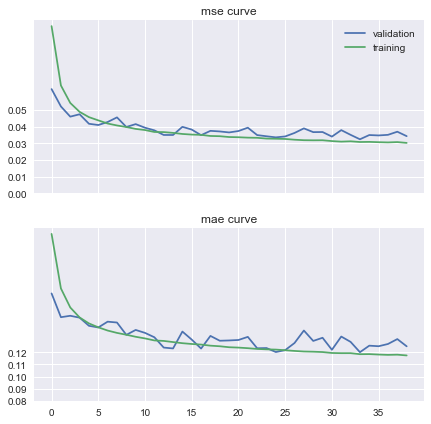

In [15]:
oFlag = "Headpose_Regression_model"
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= False
plt.rcParams['ytick.left']      = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

records     = pd.read_csv(os.path.join(oModelPath,oFlag +'.csv'))
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.01,0.02,0.03,0.04,0.05])
plt.title('mse curve',fontsize=12)

ax= plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_mae'],label="validation")
plt.plot(records['mae'],label="training")
plt.yticks([0.08,0.09,0.10,0.11,0.12])
plt.title('mae curve',fontsize=12)
ax.legend()
#save the plot
plotpath  = os.path.join(oModelPath,oFlag + '_plot.png')
plt.savefig(plotpath)
#Display
plt.show()